In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [2]:
import tensorflow as tf
from tqdm import tqdm
import cv2
import skimage.io as io
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics
import random
import time
from tqdm import tqdm
import keras

from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal, RandomUniform
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [3]:
ls = glob('Dataset/*/*')
len(ls)

75861

In [4]:
#df = pd.DataFrame()
#df['name']=ls
#df['height']=h
#df['width']=w
#df.to_csv('Dataset.csv',index=False)

In [5]:
df = pd.read_csv('Dataset.csv')
df.head()

,name,height,width
0,Dataset\Against the gods\130_001.jpg,2122,1500
1,Dataset\Against the gods\130_002.jpg,2122,1500
2,Dataset\Against the gods\130_003.jpg,2122,1500
3,Dataset\Against the gods\130_004.jpg,2122,1500
4,Dataset\Against the gods\130_005.jpg,2122,1500


In [6]:
print("Mode Height: "+str(statistics.mode(df['height'])))
print("Mode Width: "+str(statistics.mode(df['width'])))

Mode Height: 1131
Mode Width: 800


In [4]:
def crop(img, size=512):
    x,y = img.shape[0],img.shape[1]
    x1 = random.randrange(0, max(1, x - 2*size))
    y1 = random.randrange(0, max(1, y - 2*size))
    img1 = img[x1:x1+2*size,y1:y1+2*size]
    img1 = cv2.resize(img1, (size,size))
    return img1

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.83it/s]


0.6200315952301025

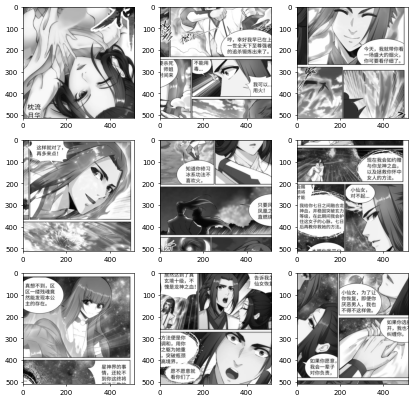

In [6]:
t1=time.time()
plt.figure(num=None, figsize=(10, 10), dpi=50, facecolor='w', edgecolor='k')
t = tqdm(range(9))
for i in t:
    img = cv2.imread(ls[i],0)
    img = crop(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #cv2.imshow('img1', img1)
    #cv2.imshow('img', img)
    #cv2.waitKey()
    #cv2.destroyAllWindows()
    plt.subplot(331+i)
    plt.imshow(img[:,:,:])
t2=time.time()
t2-t1

ML: 100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.39it/s]


0.8670659065246582

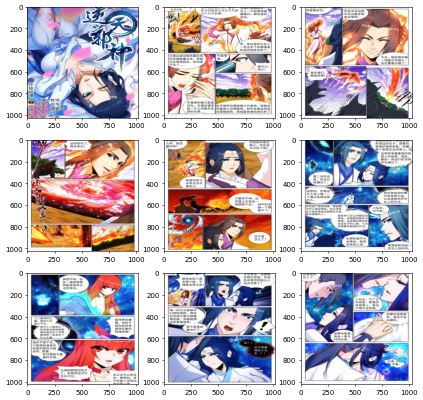

In [7]:
t = tqdm(range(9), desc='ML')
t1=time.time()
plt.figure(num=None, figsize=(10, 10), dpi=50, facecolor='w', edgecolor='k')
size = 1024
for i in t:
    img = cv2.imread(ls[i],1)
    img = crop(img,1024)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #cv2.imshow('img1', img1)
    #cv2.imshow('img', img)
    #cv2.waitKey()
    #cv2.destroyAllWindows()
    plt.subplot(331+i)
    plt.imshow(img[:,:,:])
t2=time.time()
t2-t1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 512, 512, 2)  0                                            
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 512, 512, 3)  0           input_10[0][0]                   
                                                                 input_11[0][0]                   
_________________________________________________________________________________________________

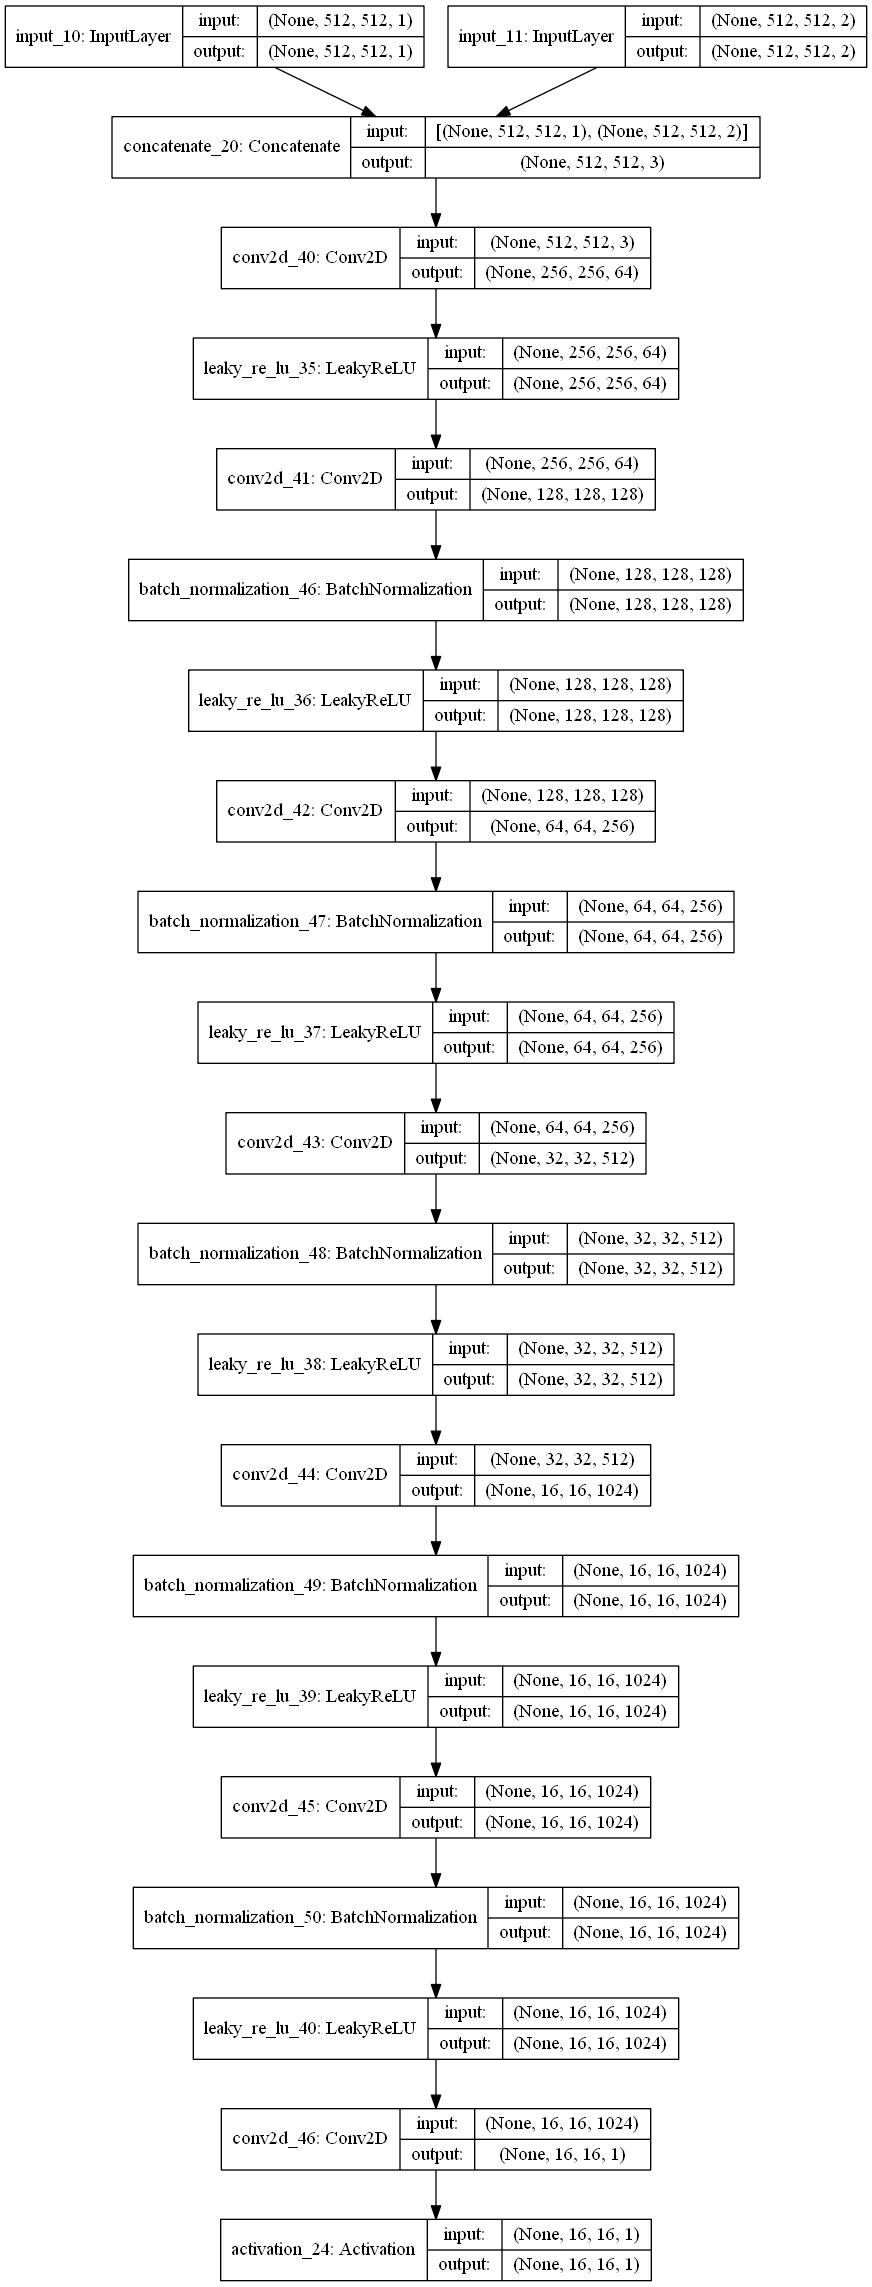

In [41]:
# define the discriminator model
def define_discriminator(g_image_shape, d_image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=g_image_shape)
    # target image input
    in_target_image = Input(shape=d_image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C1024
    d = Conv2D(1024, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(1024, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

# define image shape
g_image_shape = (512,512,1)
d_image_shape = (512,512,2)
# create the model
model = define_discriminator(g_image_shape, d_image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 256, 64) 1088        input_12[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_41 (LeakyReLU)      (None, 256, 256, 64) 0           conv2d_47[0][0]                  
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 128, 128, 128 131200      leaky_re_lu_41[0][0]             
____________________________________________________________________________________________

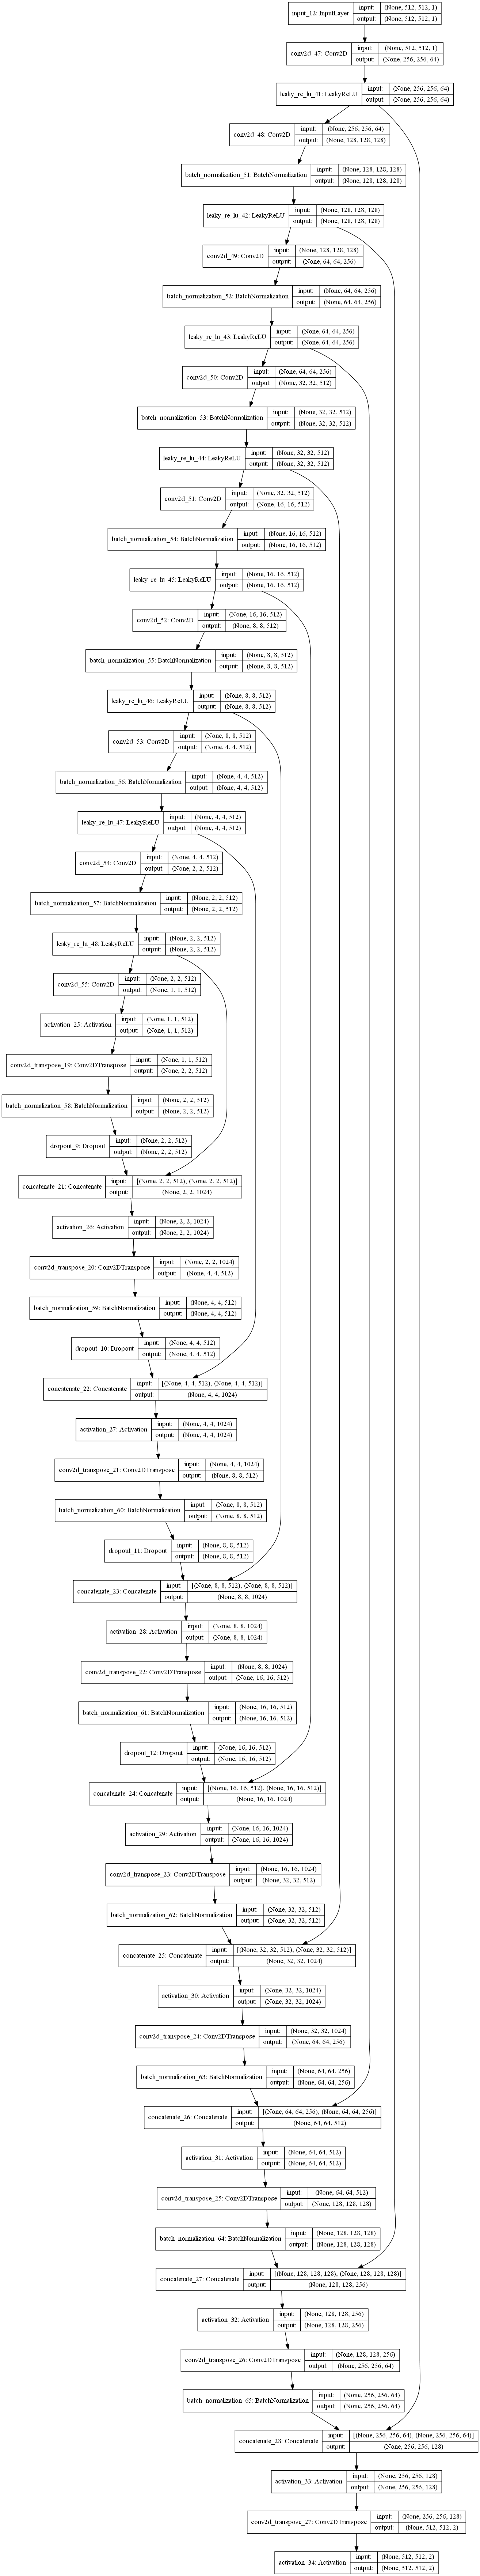

In [42]:
# example of defining a u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    e8 = define_encoder_block(e7, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e8)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d0 = decoder_block(b, e8, 512)
    d1 = decoder_block(d0, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(2, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

# define image shape
image_shape = (512,512,1)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



c:\users\aprat\.conda\envs\tf_gpu1\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 512, 512, 2)  67013250    input_1[0][0]                    
__________________________________________________________________________________________________
model_9 (Model)                 (None, 16, 16, 1)    27952577    input_1[0][0]                    
                                                                 model_10[1][0]                   
Total params: 94,965,827
Trainable params: 67,001,346
Non-trainable params: 27,964,481
__________________________________________________________________________________________________


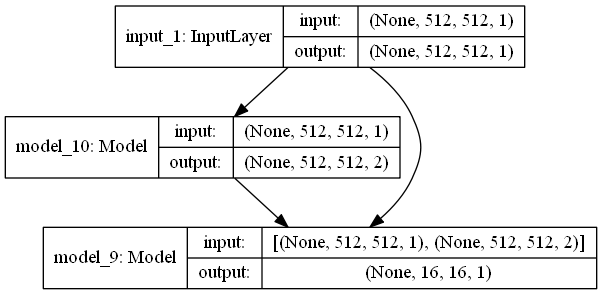

In [5]:
def define_gan(g_model, d_model, g_image_shape, d_image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=g_image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.00002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model
 
# define image shape
g_image_shape = (512,512,1)
d_image_shape = (512,512,2)
# define the models
#d_model = define_discriminator(g_image_shape, d_image_shape)
d_model = keras.models.load_model('model_unet_dis/model_450000.h5')
opt = Adam(lr=0.00002, beta_1=0.5)
d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
#g_model = define_generator(g_image_shape)
g_model = keras.models.load_model('model_unet_gan/model_450000.h5')
# define the composite model
gan_model = define_gan(g_model, d_model, g_image_shape, d_image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
# select a batch of random samples, returns images and target
def generate_real_samples(ls, n_samples, patch_shape):
    # unpack dataset
    X1, X2 = np.zeros((n_samples,512,512,1), dtype = 'float64'), np.zeros((n_samples,512,512,2), dtype = 'float64')
    img_ran = random.sample(range(0, len(ls)), n_samples)
    for i in range(n_samples):
        img_name = ls[img_ran[i]]
        img = cv2.imread(img_name)
        img = crop(img)
        #print("Real_image",img.max(), img.min())
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        X1[i,:,:,:] = img_lab[:,:,0:1]
        X2[i,:,:,:] = img_lab[:,:,1:]
    X1 = X1/127.5 -1
    X2 = X2/127.5 -1
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [7]:
def summarize_performance(step, g_model, d_model, ls, n_patch, n_batch=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(ls, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, n_patch)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) * 127.5
    X_realB = (X_realB + 1) * 127.5
    X_fakeB = (X_fakeB + 1) * 127.5
    
    X_realA = np.array(X_realA, dtype='uint8')
    X_realB = np.array(X_realB, dtype='uint8')
    X_fakeB = np.array(X_fakeB, dtype='uint8')
    
    # plot real source images
    plt.figure(figsize=(15,15), dpi=70, constrained_layout=True)
    n_samples = 3
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i,:,:,0], cmap='gray')
        
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        img = np.concatenate((X_realA[i],X_realB[i]), axis=2)
        img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
        plt.imshow(img)
        
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        img = np.concatenate((X_realA[i],X_fakeB[i]), axis=2)
        img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
        plt.imshow(img)
        
    # save plot to file
    filename1 = 'plot_unet/plot_%02d.png' % (step)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    if (step)%5000==0:
        filename_gan = 'model_unet_gan/model_%02d.h5' % (step)
        filename_dis = 'model_unet_dis/model_%02d.h5' % (step)
        g_model.save(filename_gan)
        d_model.save(filename_dis)
        #print('>Saved: %s' % (filename2))
    #print('>Saved: %s' % (filename1))

In [8]:
# train pix2pix models
def train(d_model, g_model, gan_model, ls, start, n_epochs=100, n_batch=1, n_patch=16):
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(ls) / n_batch)
    # calculate the number of training iterations
    n_steps = 100000
    # manually enumerate epochs
    t = tqdm(range(n_steps), desc='ML')
    sample_interval=200

    for i in t:
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(ls, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        #print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        t.set_description('>%d, d1[%.4f] d2[%.4f] g[%.4f]' % (i+1, d_loss1, d_loss2, g_loss))
        
        if i%2==0:
            d_model.trainable=True
            g_model.trainable=False
            #print("D_model = True, G_model = False");

        elif i%1==0:
            d_model.trainable=False
            g_model.trainable=True
            #print("D_model = False, G_model = True");
        
        if (start+i) % (sample_interval) == 0:
            summarize_performance(start+i, g_model, d_model,ls, n_patch)

In [ ]:
train(d_model, g_model, gan_model, ls, 0)

In [10]:
#plot_387000
#filename_gan = 'model_unet_gan/model_%02d.h5' % (332400)
#filename_dis = 'model_unet_dis/model_%02d.h5' % (332400)
#g_model.save(filename_gan)
#d_model.save(filename_dis)